# Geopandas

Geopandas provides a pandas-like syntax for geospatial operations.

Let's start by reading in some data.
Because it's familiar, we'll again use the US Census state boundaries and congressional districts.
The following code block will grab this data for you.

**EXERCISE:**
Run the following code block.
While it's running, annotate it with comments describing what each of the lines does.

In [12]:
import os
import zipfile

# For Python 2-3 compatibility
from future.standard_library import install_aliases
install_aliases()

import urllib.request

data_dir = "data"
if (not os.path.exists(data_dir)):
    os.mkdir(data_dir)
    
state_url = "https://www2.census.gov/geo/tiger/TIGER2016/STATE/tl_2016_us_state.zip"
state_dir = os.path.join(data_dir, "tl_2016_us_state")
state_zip = "%s.zip" % state_dir
statefile = os.path.join(state_dir, "tl_2016_us_state.shp")

if (not os.path.exists(statefile)):
    if (~os.path.exists(state_zip)):
        urllib.request.urlretrieve(state_url, state_zip)
    zipfile.ZipFile(state_zip).extractall(state_dir)

cd_url = "https://www2.census.gov/geo/tiger/TIGER2016/CD/tl_2016_us_cd115.zip"
cd_dir = os.path.join(data_dir, "tl_2016_us_cd115")
cd_zip = "%s.zip" % cd_dir
cdfile = os.path.join(cd_dir, "tl_2016_us_cd115.shp")

if (not os.path.exists(cdfile)):
    if (~os.path.exists(cd_zip)):
        urllib.request.urlretrieve(cd_url, cd_zip)
    zipfile.ZipFile(cd_zip).extractall(state_dir)

Now, let's load geopandas and read our first file.

In [9]:
import geopandas as gpd

states = gpd.read_file(statefile)

In [10]:
states

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62265597146,489902816,+38.6472854,-080.6183274,"POLYGON ((-81.747254 39.095379, -81.746354 39...."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138924199212,31386038155,+28.4574302,-082.4091478,"(POLYGON ((-82.986238 24.61065, -82.987477 24...."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143788697679,6206693598,+40.1028754,-089.1526108,"POLYGON ((-91.185295 40.637803, -91.1751 40.64..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206232257655,18929176411,+46.3158148,-094.1996628,"POLYGON ((-96.784381 46.63050399999999, -96.78..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25147754905,6983312282,+38.9466584,-076.6744939,"POLYGON ((-77.45880799999999 39.22027, -77.458..."
5,1,1,44,01219835,44,RI,Rhode Island,00,G4000,A,2677898725,1323551636,+41.5974187,-071.5272723,(POLYGON ((-71.67264399999999 41.1342919999999...
6,4,8,16,01779783,16,ID,Idaho,00,G4000,A,214042908012,2398669593,+44.3484222,-114.5588538,"POLYGON ((-116.899711 44.840609, -116.89967 44..."
7,1,1,33,01779794,33,NH,New Hampshire,00,G4000,A,23187396994,1028678842,+43.6726907,-071.5843145,"POLYGON ((-72.329899 43.600214, -72.329838 43...."
8,3,5,37,01027616,37,NC,North Carolina,00,G4000,A,125921301190,13470062955,+35.5397100,-079.1308636,"POLYGON ((-82.416738 36.072827, -82.416601 36...."
9,1,1,50,01779802,50,VT,Vermont,00,G4000,A,23873467535,1031124865,+44.0604795,-072.6733274,"POLYGON ((-73.313283 44.26413, -73.312741 44.2..."


Even though it read a shapefile, the underlying `states` object is a data frame, just like the ones you've worked with previously.
It supports all of the same Pandas operations you are already used to:

In [ ]:
states.head()

In [ ]:
states.info()

(Quick aside: If you're curious _why_ string columns have type object, [here](https://stackoverflow.com/a/21020411/2477097) is a concise answer from Stack Overflow).

# Pandas review: Working with columns

### Selecting columns

Pandas offers many ways to select individual columns.


(1) Passing the column name as a string (note the quotes!).

In [ ]:
states["NAME"]

(2) As an _attribute_ of the data frame object, via the `object.attribute` syntax

In [ ]:
states.NAME

---
**EXERCISE**:
Select the column that stores the state abbreviations.
Do this twice --- once with each method.

In [ ]:
# Answer here...

**QUESTION**:
What are some advantages of method 1?
What are some advantages of method 2?
Which method do you prefer (right now) and why?

{Answer here}

---
By replacing method 1's string with a `list`, you can select multiple columns by name.

In [ ]:
states[["NAME", "ALAND"]]

Recall that strings and lists, like all objects in Python, can be assigned to variables.
So, the above could be achieved with code like the following (pay attention to which code is and is not quoted):

In [ ]:
name_col = "NAME"
states[name_col]

In [ ]:
my_cols = [name_col, "ALAND", "AWATER"]
print my_cols

In [ ]:
states[my_cols]

---
**EXERCISE**:
Use this syntax to create a table of state names and abbreviations.

In [ ]:
# Answer here

### Creating new columns

First, let's create a "sandbox" data frame that we can safely modify by using the `DataFrame.copy` method.

In [ ]:
states2 = states.copy()

> WEEDS: The reason we can't just do something like `states2 = states` is that Pandas does a "shallow copy" by default, which means that rather than copying the entire `states` object, this just creates a new reference to the same object.
> In other words, if we just did `states2 = states`, any changes we made to `states2` _would also apply to_ `states`, because both of those variables point to the same object in the computer's memory.
> This is actually pretty useful for memory efficiency, but is a bit counterintuitive and counter to our immediate aims here---hence, `states2 = states.copy()`.

You can use similar syntax for selecting columns (Method 1) to create new ones.

In [ ]:
states2["dummy_column"] = 42
states2.info()

However, note that you _cannot_ create new columns by using the `object.attribute` syntax.
Confusingly, this *will not throw an error*, but will silently do nothing.*

> \* Technically, it creates a new attribute for the object that you will be able to access and do things with. But this is pretty non-standard practice, and if you're not careful, you could potentially accidentally overwrite important methods that prevent the data frame from working correctly. So I would avoid this. 

Note that although we passed only one value to the data frame, it was automatically "recycled" to every row.

In [ ]:
states2["dummy_column"].head()

A common use case for creating new columns is doing math on existing columns.
For example, let's convert the state land areas from square meters to hectares (1 ha = 100 m x 100 m = 10,000 m$^2$).

In [ ]:
# Note the use of 10000.0, not just 10000, to avoid integer math
states2["ALAND_ha"] = states2["ALAND"] / 10000.0
states2[["NAME", "ALAND", "ALAND_ha"]].head()

(In case you haven't seen it before, `e+06` is scientific notation, i.e. `6.22e+06` means $6.22 \times 10^6$).

---
**EXERCISE**:
Create a column `TOTAL_AREA` that is the sum of land and water area for each state.

In [ ]:
# Answer here

---
Column assignment can also be used to modify existing columns in place.

The `REGION` and `DIVISION` columns are stored as strings, but since they are all integers, let's convert them to make our lives easier.

In [ ]:
states2[["REGION", "DIVISION"]].head()

To convert columns to a different type, us the `astype()` method.

One way to do this is for multiple columns is with a `for` loop:

In [ ]:
int_cols = ["REGION", "DIVISION"]
for col in int_cols:
    states2[col] = states2[col].astype(int)
states2.info()

Fortunately, Pandas also allows this function to work on multiple columns in one go:

In [ ]:
states2[int_cols] = states2[int_cols].astype(int)
states2.info()

**QUESTION**: The `STATEFP` and `STATEENS` columns are also digits that are stored as strings.
Why might it be a good idea to keep them as strings?
(HINT: Consider ZIP codes. Look up the ZIP code for Brookline, MA, and try to store it as an integer. What happens?) 

{Your answer here}

**QUESTION**:
Why might `float` be a better type for the `ALAND` and `AWATER` columns?

{Your answer here}

**EXERCISE**:
Convert these two columns to `float`.
Use the `info()` method to confirm that your code worked.

In [ ]:
# Your answer here

**EXERCISE**:
Create new columns `FRAC_LAND` and `FRAC_WATER` containing the area fractions of land and water, respectivly, for each state.

## Pandas review: Working with rows

Somewhat confusingly, the `[]` operators in Pandas can be used to select rows, but _only_ if they are passed _slices_.

In [ ]:
states[0:4]

Again, this _only_ works for _slices_ defined with the `start:end` syntax.
The following will not work:

In [ ]:
states[1]

To select individual rows this way, you will have to be clever about creating slices containing only one number.

In [ ]:
states[3:4]

To review, the `head(n)` and `tail(n)` methods can be used to select the first and last `n` rows of a data frame.

In [ ]:
states.head(3)

In [ ]:
states.tail(4)

A more useful way to select rows is based on values of specific columns.

First, let's see how comparison operators (`==`, `>`, etc.) work on columns.

In [ ]:
states["NAME"] == "West Virginia"

Note that this returns a `Series` (Pandas class for a column) of type `bool` (boolean), with value `True` where the condition is met (only in the first row) and `False` everywhere else.

We can then use this series for subsetting.

In [ ]:
wv = states["NAME"] == "West Virginia"
states[wv]

You can combine multiple conditions using the `&` ("bitwise and") or `|` ("bitwise or") operators (but, note that each statement has to be wrapped in parentheses, `()`).

For example, this selects some really small states (area < $10^9 \text{m}^2$).

In [ ]:
states[states["ALAND"] < 10e9]

This selects really small states that are also in region 3 (again, pay attention to the parentheses).

In [ ]:
states[(states["ALAND"] < 10e9) & (states["REGION"] == 3)]

Meanwhile, this selects some really small states and some really large ones (area less than $10^9 \text{m}^2$ or greater than $10^{12} \text{m}^2$).

In [ ]:
states[(states["ALAND"] < 1e9) | (states["ALAND"] > 1e12)]

As you can see, "bitwise" here means that these operators will text the conditional statement element by element. For example:
```
(True True False) &
(True False True)
------------------
(True False False)

(True True False) |
(True False True)
------------------
(True True True)
```

These should not be confused with the logical operators `and` and `or`, which always return a single `True` or `False` and are therefore more useful in `if-else` statements.
For more information, see [this Stack Overflow post](https://stackoverflow.com/questions/22646463/and-boolean-vs-bitwise-why-difference-in-behavior-with-lists-vs-nump).

Another useful operation is the `isin` method for selecting values that are members of a specific set.

In [ ]:
my_subset = ["WV", "AK", "OK"]
states[states["STUSPS"].isin(my_subset)]

Finally, any of these conditions can be negated with the `~` ("bitwise not") operator.
This "flips" every logical element to its opposite value.
For example:

```
~(True True False) --> (False False True)
```

For example, the following code selects every state _except_ West Virginia and Florida.

In [ ]:
states[~(states.STUSPS.isin(["WV", "FL"]))]

---
**EXERCISE**:
Select states whose land area is between $10^9$ and $10^{10}$ square meters.

In [ ]:
# Answer here

**EXERCISE**:
Select states in regions 1 and 2.

In [ ]:
# Answer

**EXERCISE**: Select every state that is _not_ in region 9.

In [ ]:
# Answer

---

## Geopandas: Basics and simple maps

Let's look more closely at the structure of the `states` `DataFrame`.

In [ ]:
states.info()

Note that the last column is called `geometry` and has type `geometry`.
This column stores the spatial information used by GIS software and analysis tools.

In [ ]:
states["geometry"].head()

We are dealing with vector data, so the geometry information consists of the vector type (e.g. Polygon, MultiPolygon, Line, Point) and its corresponding coordinate pairs.

Let's see what happens if we try to plot this.

In [ ]:
states.plot()

It's not a very good one, but it's a map of the US states!

Let's see if we can zoom in on a few states using the syntax we used earlier.

In [ ]:
states[states["NAME"] == "West Virginia"].plot()

---
**EXERCISE**:
Plot the states in region 1.

In [ ]:
# Answer here

---

### Thematic maps

Geopandas makes it really easy to make thematic maps.
Simply pass a column name to the `column` argument of `plot()`.

In [ ]:
states[states.REGION.isin([1,2])].plot(column = "DIVISION")

For our current purposes, these crude, simple maps will suffice.
You can find more information on adjusting map aesthetics in the [geopandas manual](http://geopandas.org/mapping.html).

**EXERCISE**:
Figure out which `REGION` Texas is in.
Then, generate a map of that region with each state having its own color.

In [ ]:
# Answer here

## Spatial joins

Spatial joins combine information in two datasets based on their spatial relationships.
A useful application for us is to combine our data on state boundaries with our data on congressional districts.

First, let's read in the congressional district data.

In [18]:
cd116 = gpd.read_file(cdfile)
cd116.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 13 columns):
STATEFP     444 non-null object
CD115FP     444 non-null object
GEOID       444 non-null object
NAMELSAD    444 non-null object
LSAD        444 non-null object
CDSESSN     444 non-null object
MTFCC       444 non-null object
FUNCSTAT    444 non-null object
ALAND       444 non-null int64
AWATER      444 non-null int64
INTPTLAT    444 non-null object
INTPTLON    444 non-null object
geometry    444 non-null object
dtypes: int64(2), object(11)
memory usage: 45.2+ KB


In [16]:
cd116[["NAMELSAD", "geometry"]].head()

,NAMELSAD,geometry
0,Congressional District (at Large),"(POLYGON ((179.388742 51.941917, 179.404562 51..."
1,Congressional District (at Large),"POLYGON ((-75.789023 39.65979, -75.788922 39.6..."
2,Congressional District (at Large),"POLYGON ((-116.049116 48.000828, -116.049118 4..."
3,Congressional District (at Large),"POLYGON ((-104.048967 48.86953399999999, -104...."
4,Congressional District (at Large),"POLYGON ((-104.057879 44.997605, -104.050783 4..."


In [ ]:
states[["NAME", "geometry"]].head()

To combine these two, we use the `geopandas.sjoin` method.
This will take two geometries and the kind of spatial relationship by which they will be joined.
In this case, we expect that congressional districts will be `"within"` their corresponding states, which means, formally, that one object's boundaries intersect the interior of the other object.

In [19]:
districts = gpd.sjoin(cd116, states, op = "within")

Now, let's inspect the resulting object.

In [20]:
districts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 444 entries, 0 to 440
Data columns (total 28 columns):
STATEFP_left      444 non-null object
CD115FP           444 non-null object
GEOID_left        444 non-null object
NAMELSAD          444 non-null object
LSAD_left         444 non-null object
CDSESSN           444 non-null object
MTFCC_left        444 non-null object
FUNCSTAT_left     444 non-null object
ALAND_left        444 non-null int64
AWATER_left       444 non-null int64
INTPTLAT_left     444 non-null object
INTPTLON_left     444 non-null object
geometry          444 non-null object
index_right       444 non-null int64
REGION            444 non-null object
DIVISION          444 non-null object
STATEFP_right     444 non-null object
STATENS           444 non-null object
GEOID_right       444 non-null object
STUSPS            444 non-null object
NAME              444 non-null object
LSAD_right        444 non-null object
MTFCC_right       444 non-null object
FUNCSTAT_right  

In [21]:
districts.sort_values(["NAME", "NAMELSAD"])

,STATEFP_left,CD115FP,GEOID_left,NAMELSAD,LSAD_left,CDSESSN,MTFCC_left,FUNCSTAT_left,ALAND_left,AWATER_left,...,GEOID_right,STUSPS,NAME,LSAD_right,MTFCC_right,FUNCSTAT_right,ALAND_right,AWATER_right,INTPTLAT_right,INTPTLON_right
7,01,01,0101,Congressional District 1,C2,115,G5200,N,15713033442,2275872161,...,01,AL,Alabama,00,G4000,A,131173688951,4593686489,+32.7396323,-086.8434593
50,01,02,0102,Congressional District 2,C2,115,G5200,N,26266769386,306746680,...,01,AL,Alabama,00,G4000,A,131173688951,4593686489,+32.7396323,-086.8434593
93,01,03,0103,Congressional District 3,C2,115,G5200,N,19539111289,470420309,...,01,AL,Alabama,00,G4000,A,131173688951,4593686489,+32.7396323,-086.8434593
131,01,04,0104,Congressional District 4,C2,115,G5200,N,23022867957,572877020,...,01,AL,Alabama,00,G4000,A,131173688951,4593686489,+32.7396323,-086.8434593
166,01,05,0105,Congressional District 5,C2,115,G5200,N,9524306180,461150831,...,01,AL,Alabama,00,G4000,A,131173688951,4593686489,+32.7396323,-086.8434593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,55,05,5505,Congressional District 5,C2,115,G5200,N,4897030038,165147915,...,55,WI,Wisconsin,00,G4000,A,140273604537,29361386480,+44.6309071,-089.7093916
220,55,06,5506,Congressional District 6,C2,115,G5200,N,12739403869,7317994714,...,55,WI,Wisconsin,00,G4000,A,140273604537,29361386480,+44.6309071,-089.7093916
244,55,07,5507,Congressional District 7,C2,115,G5200,N,59671009717,7701303765,...,55,WI,Wisconsin,00,G4000,A,140273604537,29361386480,+44.6309071,-089.7093916
265,55,08,5508,Congressional District 8,C2,115,G5200,N,17627445037,8182671615,...,55,WI,Wisconsin,00,G4000,A,140273604537,29361386480,+44.6309071,-089.7093916


The resulting `districts` data frame now has the attributes of the `states` and `cd116` data frames combined together.
This means that we can now operate on them together.

For example, let's plot the congressional districts in Alabama.

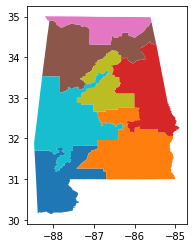

In [23]:
districts[districts.NAME == "Alabama"].plot(column = "NAMELSAD")

---
**EXERCISE**:
Plot the congressional districts of your home state and its two neighbors.

In [ ]:
# Answer here

### Exporting shapefiles

Now, we can use our new data frame to create shapefiles for individual states.
The method for doing this is `object.to_file()`.
Geopandas is smart enough to figure out the type of object to export from the file extension.

In [31]:
mystate = "Arkansas"
result = districts[districts.NAME == mystate]
result.head()

,STATEFP_left,CD115FP,GEOID_left,NAMELSAD,LSAD_left,CDSESSN,MTFCC_left,FUNCSTAT_left,ALAND_left,AWATER_left,...,GEOID_right,STUSPS,NAME,LSAD_right,MTFCC_right,FUNCSTAT_right,ALAND_right,AWATER_right,INTPTLAT_right,INTPTLON_right
9,05,01,0501,Congressional District 1,C2,115,G5200,N,50036314981,1233951818,...,05,AR,Arkansas,00,G4000,A,134771517596,2960191698,+34.8955256,-092.4446262
52,05,02,0502,Congressional District 2,C2,115,G5200,N,12894845468,303339608,...,05,AR,Arkansas,00,G4000,A,134771517596,2960191698,+34.8955256,-092.4446262
95,05,03,0503,Congressional District 3,C2,115,G5200,N,13983502473,374790427,...,05,AR,Arkansas,00,G4000,A,134771517596,2960191698,+34.8955256,-092.4446262
133,05,04,0504,Congressional District 4,C2,115,G5200,N,57856854674,1048109845,...,05,AR,Arkansas,00,G4000,A,134771517596,2960191698,+34.8955256,-092.4446262


To stay organized, let's create an `"output"` directory and store the results there.

In [32]:
outdir = "output"
if (not os.path.exists(outdir)):
    os.mkdir(outdir)
alabama.to_file(os.path.join(outdir, "alabama.shp"))

---
**EXERCISE**:
Use a `for` loop to export the shapefiles of 5 states of your choice.

### Attribute joins

In [ ]:
election_file = os.path.join(downloads, "1976-2016-president.csv")
election_full = pd.read_csv(election_file)

In [ ]:
election_full

In [ ]:
election_2016 = election_full[election_full.year == 2016]
election_2016.head()

In [ ]:
election_2016_geo = states.merge(
    election_2016,
    left_on = "STUSPS",
    right_on = "state_po"
)

In [ ]:
election_2016_geo["candidate_frac"] = election_2016_geo.candidatevotes / election_2016_geo.totalvotes

In [ ]:
election_2016_geo[
    ~(election_2016_geo.state.isin(["Alaska", "Hawaii"])) &
    (election_2016_geo.party == "democrat")
].plot(column = "candidate_frac")

For each state, get the winning candidate (the one with the most votes, by group).

In [ ]:
election_winner = election_2016_geo.loc[
    election_2016_geo.groupby("NAME")["candidatevotes"].idxmax()
]

In [ ]:
election_winner[election_winner.state != "Alaska"].plot(column = "party")

In [ ]:
election_2016_geo[election_2016_geo.state == "Maryland"]

In [ ]:
elect_sub = election_2016_geo[
    (election_2016_geo.party.isin(["republican", "democrat"])) &
    ~(election_2016_geo.writein)
][["state", "party", "candidatevotes", "geometry"]]

In [ ]:
elect_wide = elect_sub.pivot(
    index = ["state", "geometry"],
    columns = "party",
    values = "candidatevotes"
)

In [ ]:
elect_wide.info()

In [ ]:
election_2016_geo[election_2016_geo.party == "republican"].plot(
    column = "candidatevotes"
)

In [ ]:
election_2016_geo.head()

In [ ]:
states.info()

### Applying functions to columns

In the previous examples, arithmetic operators (e.g. `+`, `/`) worked without modification on Pandas `Series` (columns).
In other words, `states["ALAND"] + states["AWATER"]` is assumed to mean "add every element of `ALAND` to every element of `AWATER`".
However, many (in fact, most) functions will not work this way.

Fortunately, Pandas provides a convenient syntax for applying a function to every element of a `Series`.

Let's start by defining a simple function that adds `.shp` to the state name.
Recall that you have at least two options for doing this in Python.

In [ ]:
mystring = "Arkansas"
mystring + ".shp"

In [ ]:
"%s.shp" % mystring

Let's wrap these steps in a simple function:

In [ ]:
def create_filename(s):
    result = "%s.shp" % s
    return result

In [ ]:
create_filename("Arkansas")

In [ ]:
create_filename(states["NAME"])

Note the error: `'Series' object has no attribute 'lower'`.
That's because our code literally tried to do this:

```python
s_lowercase = states["NAME"].lower()
```

...and `lower` is not something that `Series` know how to do.

To make this work, we can instead use the `apply` method, which takes an argument that is a _function_ and applies that argument to every element of a `Series`.

In [ ]:
states["NAME"].apply(file_friendly)

Let's start by defining a simple function to convert the state name (which has upper case letters and spaces) to a more file-friendly name that is all lowercase and replaces spaces with dashes (`-`).

Let's interactively identify and test the relevant `str` methods we need to use.

In [ ]:
mystring = "West Virginia"
mystring.lower()

In [ ]:
mystring.replace(" ", "-")

Now, define a function that combines these two pieces.

In [ ]:
def file_friendly(s):
    s_lowercase = s.lower()
    s_file = s_lowercase.replace(" ", "-")
    return s_file

Test it out on a few cases.

In [ ]:
file_friendly("West Virginia")

In [ ]:
file_friendly("Washington, D.C.")

That's not a great file name -- periods and commas can confuse operating systems. Let's modify the function to remove those.

In [ ]:
def file_friendly(s):
    s_lowercase = s.lower()
    s_file = s_lowercase.replace(" ","-")
    s_file = s_file.replace(",", "")
    s_file = s_file.replace(".", "")
    return s_file

In [ ]:
file_friendly("Washington, D.C.")

Much better!

Now, if we try to use this on a `Series`, we get an error.

Another useful approach for selecting rows and columns by number is the `iloc` method.
This takes two slices, one for rows and one for columns.
Recall that a slice with no arguments (`:`) means "everything".

In [ ]:
states.iloc[0:2,:]

In [ ]:
states.iloc[3,:]

Note that unlike the previous methods, which returned `DataFrame` objects with a subset of rows (even if those `DataFrame`s only had one row!), selecting a row with `iloc` returns a `Series`.

Equivalently, the following code can be used to select a column by index.

In [ ]:
# Recall: Python uses zero-based indexing!
# NAME is the 7th column in the data frame, so its index is 6
states.iloc[:, 6]

In [ ]:
states.iloc[3,6]